# Consistent Bayes: An Agricultural Example
---

Copyright 2018 Michael Pilosov

Based on work done by ... 

# Example Summary

Suppose we have an acre of land and we are trying to decide what to plant on it. To keep this example really simple, we keep our decisions limited to just two crops: corn and soy. 
These two crops have very different yields and prices per bushel.  

We will explore how the uncertainty in crop yields affects our decision about what to plant. Our main objective is to maximize profit. 

There may very well be uncertainty in the price for each crop, but for the purposes of an initial example, we treat these quantities as if they were known/fixed (I do believe that contracts can be purchased for fixed prices ahead of time, so this may not be such a strong assumption). 

We can explore the effect of price uncertainty on our decision making as well, but for clarity and easier results visualization, we leave that for future exploration.

Conventionally, this problem would be solved with deterministic optimization (using techniques from linear programming and operations research), but these techniques have a difficult time taking into consideration all the different sources of uncertainty that plague the decision-making process. 

To this end, we define the following variables:
\begin{eqnarray}
x &=& \text{ Percentage of acreage that corn will be grown on} \\  
p_c &=& \text{ Price of Corn (\$/bushels) } \\  
y_c &=& \text{ Yield of Corn (bushels/acre) } \\  
p_s &=& \text{ Price of Soy (\$/bushels) } \\  
y_s &=& \text{ Yield of Soy (bushels/acre) } \\  
R &=& \text{ Revenue (\$) }  
\end{eqnarray}

which leads us to the following equation to describe our expected revenue:  

\begin{equation}
R = x \cdot p_c \cdot y_c + (1-x) \cdot p_s \cdot y_s
\end{equation}

**Do note that this is expected _revenue_, not _profit_. It is a certainty that there are different costs associated with planting each crop, different tax incentives, and different harvesting costs.**
_These would all be factored into a more realistic model. For simplicity, we start with a study of revenue to gain an intuition of how simulation-driven decision making can help us predict our bottom line more confidently._

We pull figures from The USDA website to set some baselines for the expected [price](https://www.ers.usda.gov/data-products/season-average-price-forecasts/) and [yield](https://www.nass.usda.gov/Charts_and_Maps/Crops_County/index.php).

<table>
<tr>
<td> <img src="https://www.nass.usda.gov/Charts_and_Maps/graphics/CR-YI-RGBChor.png"> </td>
<td> <img src="https://www.nass.usda.gov/Charts_and_Maps/graphics/SB-YI-RGBChor.png"> </td>
</tr>
</table>

As of mid-February 2018, the price of corn per bushel is around \$3.50 and soy goes for \$9.50. Recall that we are treating these as being certain. 

The yields are uncertain, and we represent these with Normal distributions centered around expected values of

**125 bushels/acre for corn**   
and   
**45 bushels/acre for soy.**    

Since the variations differ as well, we experiment with standard deviations that are multiples of 25 bushels/acre and 5 bushels/acre, respectively. We choose these values based on the legends in the figures above corresponding to a median yield. The qualitative relationship between the relative yield uncertainties is the same this way, and we can explore how our decisions are affected by uncertainty in the yields.

We are trying to decide on a good value for $x$, which determines how we allocate our acre of land. 
For those wondering _why just one acre?_, consider that more acreage leads to a constant multiple of profit. The decision making is thus framed as a percentage so this generalization is easily made. 

Figuring in different yield uncertainties depending on individual plots of land can certainly be taken into account but is outside the scope of this preliminary investigation.

--- 
### Import Libraries
_tested with python 3.6 on 02/11/18_

In [1]:
# Mathematics and Plotting
from HelperFuns import * # pyplot wrapper functions useful for visualizations, numpy, scipy, etc.
# %matplotlib inline
%matplotlib notebook
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = 10, 5
from cbayes import sample, solve, distributions
# Interactivity
from ipywidgets import *

---
## Define Functions

In [2]:
def expected_revenue(lam):
    if lam.shape[1] != 3:
        raise(AttributeError('Your lambda must be three-dimensional'))
    # our first column is x, second is y_c, third is y_s
    percentage_corn = lam[:,0]
    corn_productivity = lam[:,1]
    soy_productivity = lam[:,2]
    corn_yield = percentage_corn*corn_productivity
    soy_yield = (1.0 - percentage_corn)*soy_productivity
    return (3.5*corn_yield + 9.5*soy_yield)


--- 

# Sample from Prior


In [3]:
num_samples = int(1E4) # number of input samples (N)
uncertainty_multiple = 0.5

input_dim = 3 # Specify input space dimension (n)
s_set = sample.sample_set(size=(num_samples, input_dim))
PtO_fun = expected_revenue

# s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': 0, 'scale': 1}, dim=0) # uniform distribution
s_set.set_dist('uni', kwds={'loc': 0, 'scale': 1}, dim=0) # uniform distribution
s_set.set_dist('normal', kwds={'loc': 125, 'scale': 25*uncertainty_multiple}, dim=1)
s_set.set_dist('normal', kwds={'loc': 45, 'scale': 5*uncertainty_multiple}, dim=2)

s_set.generate_samples()

lam = s_set.samples # create a pointer for ease of reference later with plotting.

### Visualize Prior 

In [4]:
widgets.interactive(pltdata, data = fixed(lam), inds = fixed(None), 
                    N = widgets.IntSlider(value=5000, min = 100, max=10000, step=100, continuous_update=False), 
                    eta_r = fixed(None), space=fixed(0.05), svd=widgets.Checkbox(value=False), color=widgets.Text(value="orange", continuous_update=False),
                    view_dim_1 = widgets.IntSlider(value=1, min=0, max=input_dim-1, step=1, continuous_update=False), 
                    view_dim_2 = widgets.IntSlider(value=input_dim-1, min=0, max=input_dim-1, step=1, continuous_update=False))


interactive(children=(IntSlider(value=1, continuous_update=False, description='view_dim_1', max=2), IntSlider(value=2, continuous_update=False, description='view_dim_2', max=2), IntSlider(value=5000, continuous_update=False, description='N', max=10000, min=100, step=100), Text(value='orange', continuous_update=False, description='color'), Checkbox(value=False, description='svd'), Output()), _dom_classes=('widget-interact',))

---
# Compute Data Space $O(\Lambda) = \mathcal{D}$ 

Format: `(n_dims, n_samples)`  

In [5]:
p_set = sample.map_samples_and_create_problem(s_set, PtO_fun)
D = p_set.output.samples

# this is how we handle trying to infer the dimension based on what the map put out.
try:
    output_dim = D.shape[1] # if your function was coded correctly, you should have an (n, d) data space.
except IndexError:
    print(Warning("Warning: Your map might be returning the wrong dimensional data."))
    try:
       output_dim = D.shape[0] 
    except IndexError:
        print(Warning("Warning: Guessing it's 1-dimensional."))
        output_dim = 1
print('dimensions :  lambda = '+str(lam.shape)+'   D = '+str(D.shape) )

dimensions :  lambda = (10000, 3)   D = (10000, 1)


# Compute Push-Forward of the Prior $P_{O(\Lambda)}$
_ ... i.e. Characterize the Data Space_

In [6]:
# Interactive Marginal Visualization
p_set.compute_pushforward_dist()
pf_dist = p_set.pushforward_dist

In [7]:
widgets.interactive(pltdata, data = fixed(pf_dist), inds = fixed(None), 
        N = widgets.IntSlider(value=5000, min = 100, max=10000, step=100, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="brown", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='view_dim_1', max=0), IntSlider(value=0, continuous_update=False, description='view_dim_2', max=0), IntSlider(value=5000, continuous_update=False, description='N', max=10000, min=100, step=100), Text(value='brown', continuous_update=False, description='color'), Output()), _dom_classes=('widget-interact',))

## Some observations at this time.

From the plot above, we are able to get a sense of our potential profits. It seems like we can mnake between \$300 and \$550 per acre, depending on the choices we make (_which choices? We'll find out soon._).

The peak in the distribution above represents your expected revenue from this acre of land across all possible decisions you might make. This is about \$425. 

We use this observation to define our _observed probability measure_, which represents our desired outcome. Since we can expect \$425, let us shoot for earning $\$475\pm 50$ instead. A potential \$100 per-acre revenue gain over guessing.

# Define Observed Probability Measure $P_\mathcal{D}$

In [8]:
desired_revenue = 500
desired_range = 50
# p_set.set_observed_dist('uni', {'loc':desired_revenue-0.5*desired_range, 'scale':desired_range}) # default is normal based on the data space # for function choice = 1
p_set.set_observed_dist('normal', {'loc':desired_revenue, 'scale':desired_range/6}) # default is normal based on the data space # for function choice = 1

obs_dist = p_set.observed_dist # this is define a pointer for ease of reference.

widgets.interactive(pltdata, data = fixed(obs_dist), inds = fixed(None), 
        N = widgets.IntSlider(value=10000, min = 100, max=50000, step=100, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="wine", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))


interactive(children=(IntSlider(value=0, continuous_update=False, description='view_dim_1', max=0), IntSlider(value=0, continuous_update=False, description='view_dim_2', max=0), IntSlider(value=10000, continuous_update=False, description='N', max=50000, min=100, step=100), Text(value='wine', continuous_update=False, description='color'), Output()), _dom_classes=('widget-interact',))

The bumpiness in the figure is solely a result of visualization choices for expediency.

---

At this point we have performed the computations we need to. We have evaluated the input points through our map and performed a KDE on them. It would be useful at this point to save this object and/or its evaluation at every point in the data space for later re-use. Doing so here would be an appropriate place. 

--- 

# Accept/Reject Sampling of Posterior

Since we have already used the samples in our prior to compute the pushforward density, we can re-use these with an accept/reject algorithm to get a set of samples generated from the posterior according to the solution of the stochastic inverse problem as outlined in the Consistent Bayes formulation. 

In [9]:
p_set.set_ratio()
eta_r = p_set.ratio
solve.problem(p_set)

In [10]:
accept_inds = p_set.accept_inds
lam_accept = p_set.input.samples[accept_inds,:]
num_accept = len(accept_inds)
print('Number accepted: %d = %2.2f%%'%(num_accept, 100*np.float(num_accept)/num_samples))

Number accepted: 106 = 1.06%


## Visualize Posterior Density
### (Visualize Accept/Reject Samples)


In [11]:
widgets.interactive(pltdata, data = fixed(lam), inds = fixed(accept_inds), 
        N = widgets.IntSlider(value=num_accept/2, min = 2, max=num_accept+1, step=1, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=widgets.Checkbox(value=False), color=widgets.Text(value="orange", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=input_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=input_dim-1, min=0, max=input_dim-1, step=1, continuous_update=False))

# You will visualize the accepted samples in a subset of size N of the input samples. 
# This is mostly for faster plotting, but also so you can see the progression of accepted sampling in the algorithm.


interactive(children=(IntSlider(value=0, continuous_update=False, description='view_dim_1', max=2), IntSlider(value=2, continuous_update=False, description='view_dim_2', max=2), IntSlider(value=53, continuous_update=False, description='N', max=107, min=2), Text(value='orange', continuous_update=False, description='color'), Checkbox(value=False, description='svd'), Output()), _dom_classes=('widget-interact',))

---
# Now what? 

Well, we can...

## _Visualize the Quality of our SIP Solution by Comparing it to the Observed_
_We compare the push-forward of the posterior using accepted samples against the observed density_  
_(SIP = Stochastic Inverse Problem)_
### Observed:

In [12]:
widgets.interactive(pltdata, data = fixed(obs_dist), inds = fixed(None), 
        N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="wine", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='view_dim_1', max=0), IntSlider(value=0, continuous_update=False, description='view_dim_2', max=0), IntSlider(value=500, continuous_update=False, description='N', max=5000, min=100, step=100), Text(value='wine', continuous_update=False, description='color'), Output()), _dom_classes=('widget-interact',))

## Pushforward of Posterior:

In [13]:
widgets.interactive(pltdata, data = fixed(D), inds = fixed(accept_inds), 
        N = widgets.IntSlider(value=num_accept/2, min = 2, max=num_accept-1, step=1, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="eggplant", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))


interactive(children=(IntSlider(value=0, continuous_update=False, description='view_dim_1', max=0), IntSlider(value=0, continuous_update=False, description='view_dim_2', max=0), IntSlider(value=53, continuous_update=False, description='N', max=105, min=2), Text(value='eggplant', continuous_update=False, description='color'), Output()), _dom_classes=('widget-interact',))

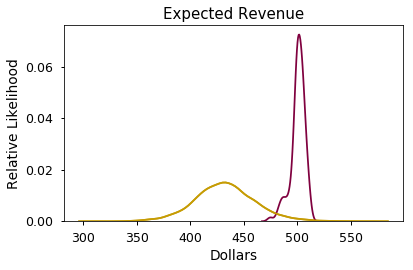

In [14]:
sb.set_context("notebook", font_scale=1.25)
str2 = "Expected Revenue\n(after)"
str1 = "Expected Revenue\n(before)"

f = sb.kdeplot(D[accept_inds,0], color=sb.xkcd_rgb['wine'])
f.set_title(str2)
f.set_xlabel("Dollars")
f.set_ylabel("Relative Likelihood")

g = f.get_figure()
g.tight_layout()
g.savefig("expected_rev_after.png")
f.cla()


f = sb.kdeplot(D[:,0], color=sb.xkcd_rgb['ocre'])
f.set_title(str1)
f.set_xlabel("Dollars")
f.set_ylabel("Relative Likelihood")

g = f.get_figure()
g.tight_layout()
g.savefig("expected_rev_before.png")

f = sb.kdeplot(D[accept_inds,0], color=sb.xkcd_rgb['wine'])
f.set_title(str2)
f.set_xlabel("Dollars")
f.set_ylabel("Relative Likelihood")

f = sb.kdeplot(D[:,0], color=sb.xkcd_rgb['ocre'])
f.set_title("Expected Revenue")
f.set_xlabel("Dollars")
f.set_ylabel("Relative Likelihood")

g = f.get_figure()
g.tight_layout()
g.savefig("expected_both.png")

## Verify our parametric test statistics.
Let's see if the pushforward of the posterior results in a sample mean and standard deviation that are close to the observed.

In [15]:
# From our propogated decisions:
[np.mean(D[accept_inds,:]), np.std(D[accept_inds,:])]

[500.7220134735435, 6.57983344209532]

In [16]:
# From the observed (target) distribution:
[p_set.observed_dist.mean(), p_set.observed_dist.std()]

[500.0, 8.333333333333334]

They look pretty good! Now go back to the [Sampling Section](#Sample-from-Prior) and change the distribution on the prior or choose another example problem.

# Future Work

A perhaps more nuanced approach would actually be to solve a 1D problem with a stochastic map in place of 3D problem where 2 of the parameters being used are representing the uncertainty in yields. 

These are different questions though.

Inverting a distribution through a stochastic map would identify a strategy that is robust to the uncertainty. 

Inverting through a deterministic map with random variables as parameters identifies regions of certainty that inform the decision process (informs the feedback loop with the decision-maker). 